# Make intended "Figure 1" for spectral ice paper

### Jonah Shaw, 09/20/2021

Four panels (potentially more) with contour plots of observed monthly trends  
1. dT/dt (GISStemp or HadCrut?)  
2. Ice extent trend (need to find gridded monthly product)
3. CERES ASR (03/2000 - 02/2020 or 01/2001 - 01/2020)
4. CERES OLR (03/2000 - 02/2020 or 01/2001 - 01/2020)

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load datasets

CERES, GISStemp, HadSST, NSIDC

## Load GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [2]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [3]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [4]:
giss_tsel = giss1.sel(time=slice('2001-01','2020-12'))['air']

In [5]:
giss1.close()

## Load HadSST3.1 data

Haven't used this before, but trying to find something with temperature records from the Arctic.

In [6]:
hadsst_path = '/glade/work/jonahshaw/obs/HadSST3.0/'
hadsst_file = 'HadSST.3.1.1.0.median.nc'

In [7]:
hadsst = xr.open_dataset('%s/%s' % (hadsst_path,hadsst_file))['sst']

## Load NSIDC data

Using the G10010 V2 product for now.

The ancilliary data has the lat/lon point for each gridcell

In [6]:
g10010_path = '/glade/work/jonahshaw/obs/NSIDC/G10010_V2/'
g10010_file = 'G10010_sibt1850_v2.0.nc'

In [7]:
nsidc_seaice = xr.open_dataset('%s/%s' % (g10010_path,g10010_file))

Using the G02202 V4 product (recommended by Walt Meier)

In [8]:
g02202_path = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/'

In [9]:
g02202_files = glob.glob('%s*.nc' % (g02202_path))
g02202_files.sort()

In [12]:
g02202_ancilliary = xr.open_dataset(g02202_files[0])
g02202_test = xr.open_dataset(g02202_files[1])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigne

In [19]:
g02202_test['cdr_seaice_conc_monthly'][0]

<xarray.DataArray 'cdr_seaice_conc_monthly' (y: 448, x: 304)>
array([[0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       [0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       [0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       ...,
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ],
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ],
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2000-01-01
    xgrid    (x) float32 -3837500.0 -3812500.0 ... 3712500.0 3737500.0
    ygrid    (y) float32 5837500.0 5812500.0 5787500.0 ... -5312500.0 -5337500.0
Dimensions without coordinates: y, x
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]

This is wack

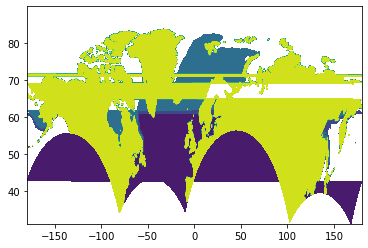

In [23]:
plt.contourf(g02202_ancilliary['longitude'],g02202_ancilliary['latitude'],g02202_test['cdr_seaice_conc_monthly'][0])

## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

In [8]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [9]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data
if os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
    ceres_asr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)
    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)) or (not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
    
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
        ceres_asr = all_ceres['solar_mon'] - all_ceres['toa_sw_all_mon']
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = all_ceres['toa_lw_all_mon']

## Load AIRS data

Combine ascending and descending total water vapor retrievals (equal averaging)
Remember that an AIRS/PREFIRE satellite simulator will need to subsample time of orbit to capture correct patterns.


I also have to get the units here. Jen suggested mm, which is maybe reasonable?

Seems legit after looking after this:
https://earthobservatory.nasa.gov/global-maps/MYDAL2_M_SKY_WV

The CESM2 variable TMQ is in units of kg/m^2.

If rho is 1000 kg / m^3, 1mm x 1m x 1m is 0.001 m^3 so the units are interchangeable.

In [38]:
airs_tseries_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'

In [39]:
tmq_a_file = 'AIRS.TotH2OVap_A.200209-202012.L3.RetStd.v7.nc'
tmq_d_file = 'AIRS.TotH2OVap_D.200209-202012.L3.RetStd.v7.nc'

In [57]:
tmq_a = xr.open_dataset('%s/%s' % (airs_tseries_dir,tmq_a_file))
tmq_d = xr.open_dataset('%s/%s' % (airs_tseries_dir,tmq_d_file))

tmq_a = tmq_a.rename({'TotH2OVap_A':'TotH2OVap'})
tmq_d = tmq_d.rename({'TotH2OVap_D':'TotH2OVap'})

In [61]:
_tmq_a = tmq_a['TotH2OVap'].assign_coords({'orbit':0}).expand_dims('orbit')
_tmq_d = tmq_d['TotH2OVap'].assign_coords({'orbit':1}).expand_dims('orbit')

In [81]:
tmq_both = xr.merge([_tmq_a,_tmq_d])
tmq_net = tmq_both.mean(dim='orbit')['TotH2OVap']

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [10]:
def linregress1d_np(data, times):
#     print(f"data: {data.shape} | x: {times.shape}") # different formatting syntax
    return stats.linregress(times, data)

In [11]:
def vectorized_linregress(data):
    '''
    Package for my vectorized linregress call. Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
    linregress1d_np,  # first the function
    data,  # now arguments in the order expected by 'regress1_np'
    data.year,
    input_core_dims=[["year"], ["year"],],
    output_core_dims= [[] for _ in range(5)],
    exclude_dims=set(("year",)),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[data.dtype for _ in range(5)], # one per output
    )
    
    return regressed_month

In [12]:
def compute_trends_n_signif(subset_data):
    '''
    Package the trend calculating lines to save space.
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time'))
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):

        _yearlydata = _month.groupby('time.year').mean('time')    
        regressed_month = vectorized_linregress(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        _trends[ii] = regressed_month[0]
        _rvalues[ii] = regressed_month[2]
        _pvalues[ii] = regressed_month[3]

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Calculate trends and statistical significance

#### CERES ASR

In [13]:
# Subset data so computations are lighter and significance tests make sense
ceres_asr_subset = ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [14]:
asr_trends,asr_statsig,asr_notnull = compute_trends_n_signif(ceres_asr_subset)

#### CERES OLR

In [15]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [16]:
olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif(ceres_olr_subset)

#### Temperature from GISStemp

In [17]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)).mean('lon')

In [18]:
gisstemp_trends,gisstemp_statsig,gisstemp_notnull = compute_trends_n_signif(gisstemp_subset)

#### Total WV column from AIRS

In [82]:
# Threw an error when the end date was 12-31
airs_tmq_subset = tmq_net.sel(time=slice('2003-01-01','2020-12-30'),lat=slice(None,58)).mean('lon')

In [86]:
wv_trends,wv_statsig,wv_notnull = compute_trends_n_signif(airs_tmq_subset)

#### Ice Concentration from NSIDC G10010

In [19]:
try:
    nsidc_seaice = nsidc_seaice.rename({'latitude':'lat','longitude':'lon'})
except:
    pass

# Subset by time and latitude
g10010_tsel = nsidc_seaice.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(90,59))

# Need to perform a masked and weighted average because areas are not constant and land cells must be masked
g10010_subset = masked_average(g10010_tsel['seaice_conc'],dim=['lon'],
                                      weights=g10010_tsel['Gridcell_Area'],mask=(g10010_tsel['LandRegion_mask']==20))

In [20]:
g10010_trends,g10010_statsig,g10010_notnull = compute_trends_n_signif(g10010_subset)

### Plot summary data

#### Wrap data for better visualization

In [87]:
gisstemp_trends_wrapped = xr.concat([gisstemp_trends,gisstemp_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_statsig_wrapped = xr.concat([gisstemp_statsig,gisstemp_statsig[0].assign_coords({'month':13})],dim='month')

g10010_trends_wrapped = xr.concat([g10010_trends,g10010_trends[0].assign_coords({'month':13})],dim='month')
g10010_statsig_wrapped = xr.concat([g10010_statsig,g10010_statsig[0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([asr_trends,asr_trends[0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([asr_statsig,asr_statsig[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([olr_statsig,olr_statsig[0].assign_coords({'month':13})],dim='month')

wv_trends_wrapped = xr.concat([wv_trends,wv_trends[0].assign_coords({'month':13})],dim='month')
wv_statsig_wrapped = xr.concat([wv_statsig,wv_statsig[0].assign_coords({'month':13})],dim='month')

Text(0.5, 0.95, 'Observed Trends')

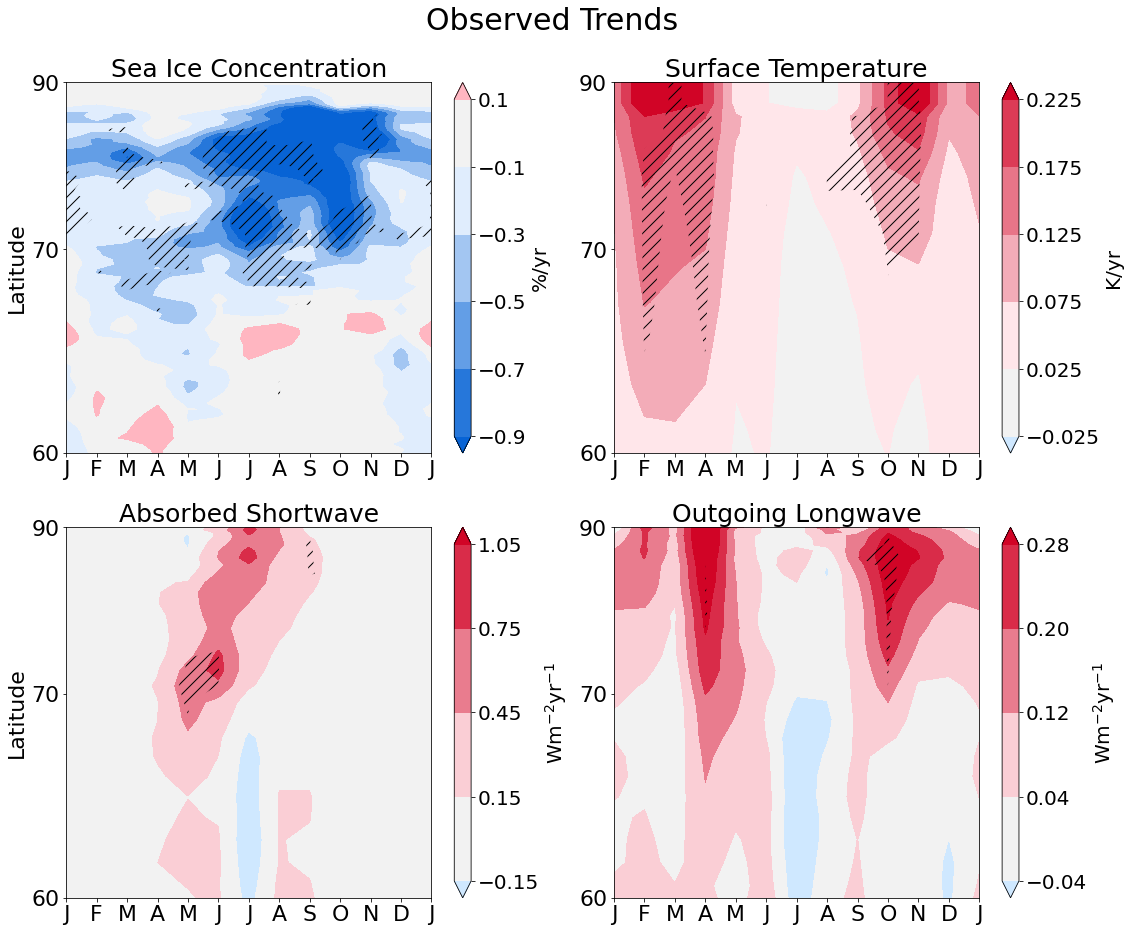

In [22]:
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
fig1.subplots_adjust(wspace=0.2,hspace=0.2)

axes = axs.flat

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)

axes[0].set_ylabel('Latitude',fontsize=22)
axes[2].set_ylabel('Latitude',fontsize=22)
    
lat_weighted0 = np.sin(np.pi/180*g10010_trends['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.9,0.11,0.2),vmin=-0.9,vmax=0.9)
im0.cmap.set_over('lightpink')
stip = axes[0].contourf(g10010_statsig_wrapped['month'],lat_weighted0,g10010_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice Concentration',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='%/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*gisstemp_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_trends_wrapped['month'],lat_weighted1,gisstemp_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im1.cmap.set_under((0.81,0.91,1.00))
stip = axes[1].contourf(gisstemp_statsig_wrapped['month'],lat_weighted1,gisstemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('Surface Temperature',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='K/yr',fontsize=20)

lat_weighted2 = np.sin(np.pi/180*asr_trends['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap2,extend='both',levels=np.arange(-0.15,1.06,0.30),vmin=-1.05,vmax=1.05)
im2.cmap.set_under((0.81,0.91,1.00))
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('Absorbed Shortwave',fontsize=25)
cbar2 = plt.colorbar(im2,ax=axes[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

lat_weighted3 = np.sin(np.pi/180*olr_trends['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im3.cmap.set_under((0.81,0.91,1.00))
stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('Outgoing Longwave',fontsize=25)
cbar3 = plt.colorbar(im3,ax=axes[3])
cbar3.ax.tick_params(labelsize=20)
cbar3.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

fig1.suptitle('Observed Trends',fontsize=30,y=0.95)

In [52]:
to_png(fig1,'observedtrends_4panel')

### Add water vapor from AIRS in 5th (3rd) panel

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average')

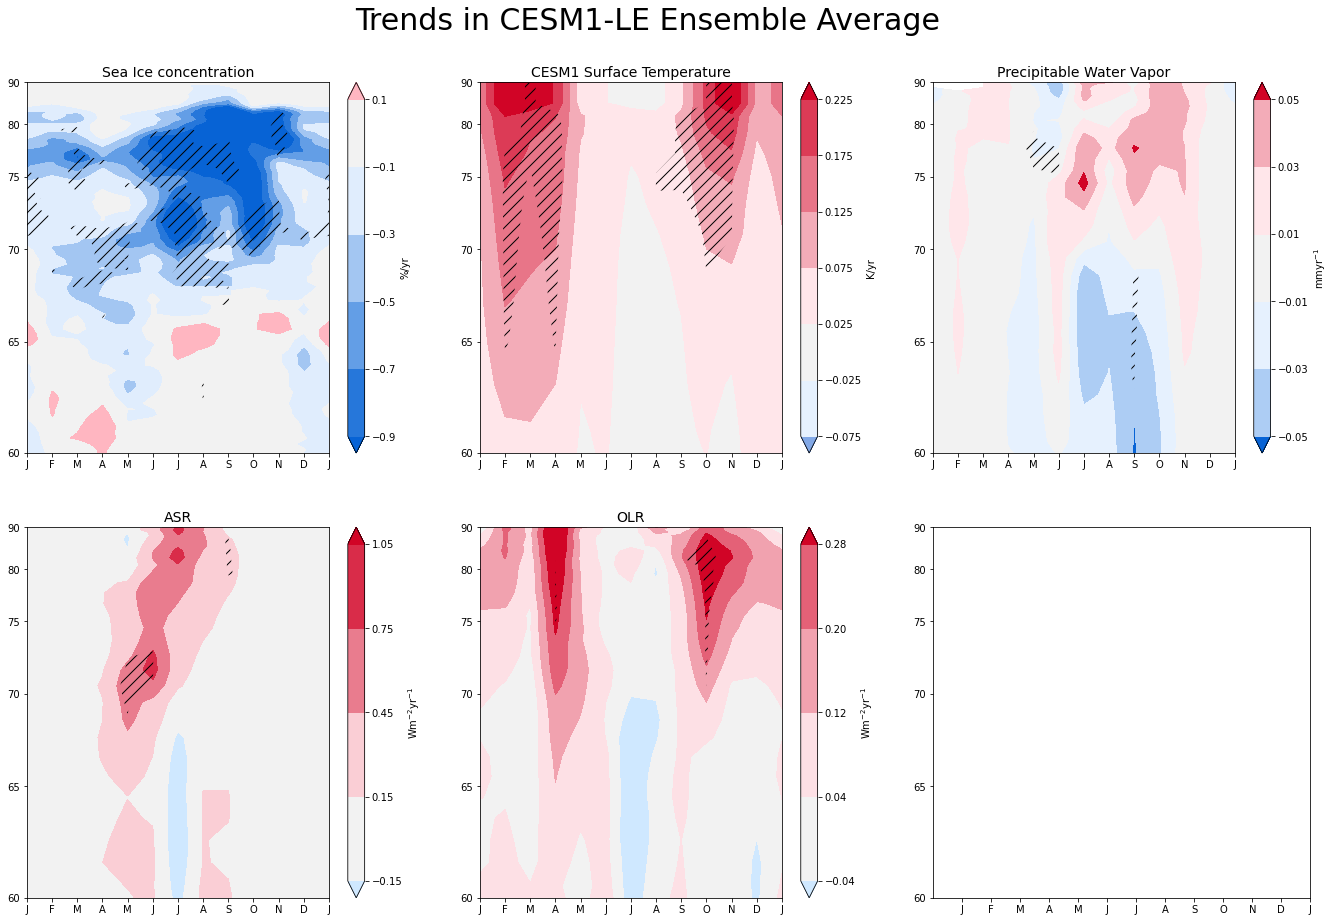

In [98]:
fig1,axs = plt.subplots(nrows=2,ncols=3,figsize=(23,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*g10010_trends_wrapped['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=cmap0,vmin=-0.9,vmax=0.9,levels=np.arange(-0.9,0.11,0.2),extend='both')
im0.cmap.set_over('lightpink') # (0.51,0.66,0.9)
stip = axes[0].contourf(g10010_statsig_wrapped['month'],lat_weighted0,g10010_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*gisstemp_trends_wrapped['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_trends_wrapped['month'],lat_weighted1,gisstemp_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=cmap1,vmin=-0.25, vmax=0.25,levels=np.arange(-0.075,0.2251,0.05),extend='both')
im1.cmap.set_under((0.51,0.66,0.9))
stip = axes[1].contourf(gisstemp_statsig_wrapped['month'],lat_weighted1,gisstemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*wv_trends_wrapped['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(wv_trends_wrapped['month'],lat_weighted2,wv_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=cmap2,vmin=-0.1, vmax=0.10,extend='both',levels=np.arange(-0.05,0.051,0.02))
# im2.cmap.set_under('blue') # (0.81,0.91,1.00)
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('Precipitable Water Vapor',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='mmyr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(asr_trends_wrapped['month'],lat_weighted3,asr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap3,vmin=-1.05, vmax=1.05,levels=np.arange(-0.15,1.06,0.30),extend='both')
im3.cmap.set_under((0.81,0.91,1.00))
stip = axes[3].contourf(asr_statsig_wrapped['month'],lat_weighted3,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('ASR',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted4 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
cmap4 = copy.copy(palette)
im4 = axes[4].contourf(olr_trends_wrapped['month'],lat_weighted4,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap4,vmin=-0.36,vmax=0.36,levels=np.arange(-0.04,0.36,0.08),extend='both')
im4.cmap.set_under((0.81,0.91,1.00))
stip = axes[4].contourf(olr_statsig_wrapped['month'],lat_weighted4,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[4].set_title('OLR',fontsize=14)
plt.colorbar(im4,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average',fontsize=30,y=0.95)

#### Plot with same colorbars as ensemble range

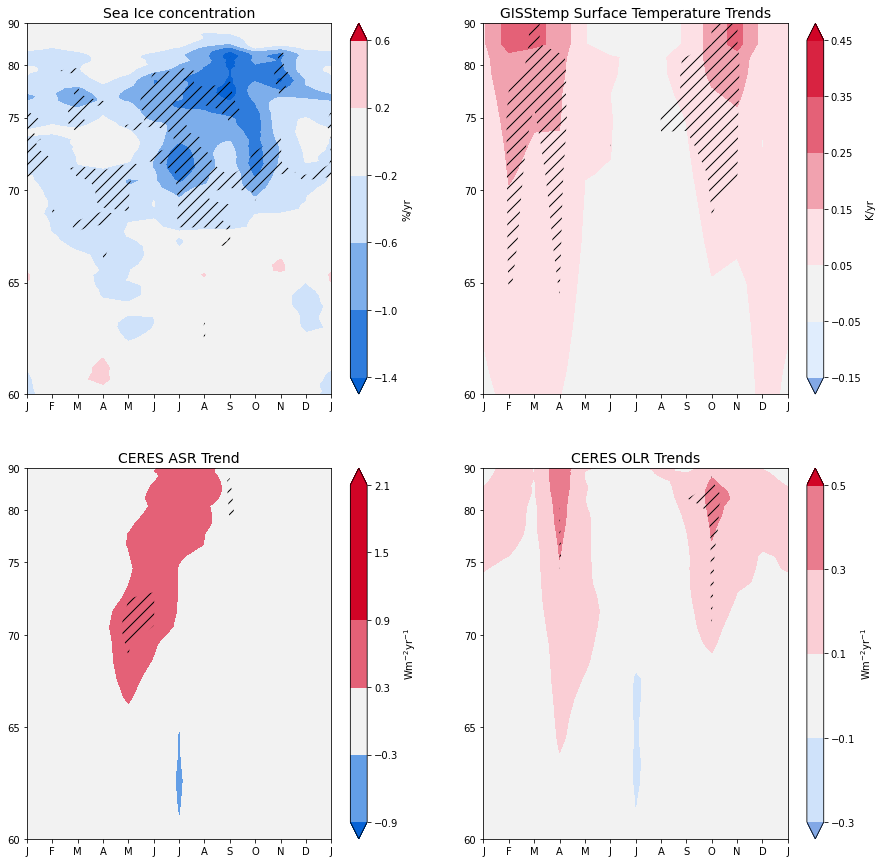

In [27]:
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*g10010_trends['lat'])
im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
                       cmap=palette,vmin=-1.4, vmax=1.4,levels=np.arange(-1.4,0.61,0.4),extend='both')
stip = axes[0].contourf(g10010_statsig_wrapped['month'],lat_weighted0,g10010_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')
    
lat_weighted1 = np.sin(np.pi/180*gisstemp_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_trends_wrapped['month'],lat_weighted1,gisstemp_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,vmin=-0.45, vmax=0.45,levels=np.arange(-0.15,0.451,0.1),extend='both')
im1.cmap.set_under((0.51,0.66,0.9))
stip = axes[1].contourf(gisstemp_statsig_wrapped['month'],lat_weighted1,gisstemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'),
                       cmap=palette,vmin=-0.9, vmax=0.90,levels=np.arange(-0.9,2.11,0.6),extend='both')
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,vmin=-0.7, vmax=0.7,levels=np.arange(-0.3,0.7,0.2),extend='both')
im3.cmap.set_under((0.51,0.66,0.9))
stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')


### Do line plots as suggested by Will B.

In [31]:
gisstemp_wgts = np.cos(gisstemp_trends_wrapped.lat*np.pi/180)
gisstemp_line = masked_average(gisstemp_trends_wrapped,dim='lat',weights=gisstemp_wgts)

In [36]:
g10010_wgts = np.cos(g10010_trends_wrapped.lat*np.pi/180)
g10010_line = masked_average(g10010_trends_wrapped,dim='lat',weights=g10010_wgts)

In [38]:
asr_wgts = np.cos(asr_trends_wrapped.lat*np.pi/180)
asr_line = masked_average(asr_trends_wrapped,dim='lat',weights=asr_wgts)

In [42]:
olr_wgts = np.cos(olr_trends_wrapped.lat*np.pi/180)
olr_line = masked_average(olr_trends_wrapped,dim='lat',weights=olr_wgts)

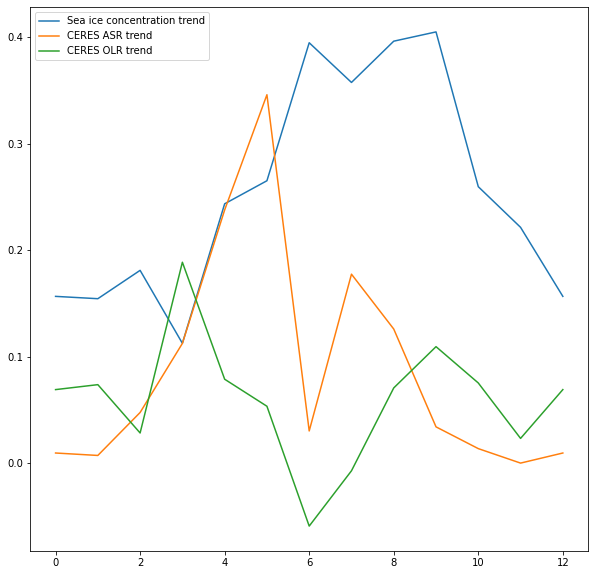

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(-1*g10010_line,label='Sea ice concentration trend')
ax.plot(asr_line,label='CERES ASR trend')
ax.plot(olr_line,label='CERES OLR trend')
ax.plot(gisstemp_line,label='GISTEMP Temperature trend')

plt.legend()

### Create plots with ocean/continent masks

This will be unchanged for the sea ice, so I just need to interpolate the ocean mask into the CERES and GISStemp grids and then apply them separately.

In [123]:
landmask = xr.where(g10010_tsel['LandRegion_mask']==20,1,0)

In [124]:
ceres_landmask = landmask.interp_like(ceres_asr['ASR'][0])

In [125]:
gisstemp_landmask = landmask.interp_like(giss_tsel[0])

The mask is smeared when interpolated to the lower resolution, so I will need a cutoff value.

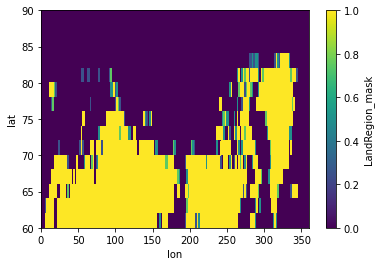

In [41]:
gisstemp_landmask.sel(lat=slice(90,60)).plot()

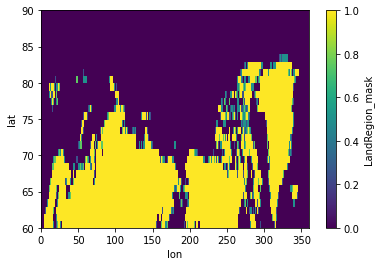

In [42]:
ceres_landmask.sel(lat=slice(60,90)).plot()

### Recompute trends with masked arrays

Sea will be mask < 0.1. Land will be mask > 0.9.

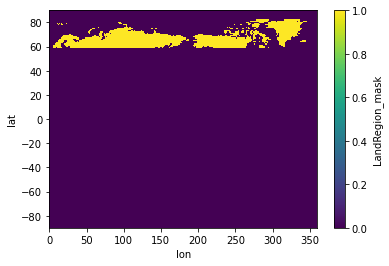

In [43]:
(ceres_landmask>0.9).plot()

#### CERES ASR

In [126]:
# Mask convention is to hide the pass gridcells
# Only take cells with <10% land coverage
ceres_asr_seasubset = masked_average(ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)),dim=['lon'],mask=ceres_landmask>0.1)
# Only take cells with >90% land coverage
ceres_asr_landsubset = masked_average(ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)),dim=['lon'],mask=ceres_landmask<0.9)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### CERES OLR

In [127]:
# Mask convention is to hide the pass gridcells
# Only take cells with <10% land coverage
ceres_olr_seasubset = masked_average(ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)),dim=['lon'],mask=ceres_landmask>0.1)
# Only take cells with >90% land coverage
ceres_olr_landsubset = masked_average(ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)),dim=['lon'],mask=ceres_landmask<0.9)

#### GISStemp

In [128]:
gisstemp_seasubset = masked_average(giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)),dim=['lon'],mask=gisstemp_landmask>0.1)

gisstemp_landsubset = masked_average(giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)),dim=['lon'],mask=gisstemp_landmask<0.9)

The sea ice data is already masked so I don't need to change anything, though I could think about adding something else for the continental data...what though?

### Compute trends on masked data

#### CERES ASR observations

In [129]:
asr_seasubset_trends,asr_seasubset_statsig,asr_seasubset_notnull = compute_trends_n_signif(ceres_asr_seasubset)

In [130]:
asr_landsubset_trends,asr_landsubset_statsig,asr_landsubset_notnull = compute_trends_n_signif(ceres_asr_landsubset)

#### CERES OLR observations

In [131]:
olr_seasubset_trends,olr_seasubset_statsig,olr_seasubset_notnull = compute_trends_n_signif(ceres_olr_seasubset)

In [132]:
olr_landsubset_trends,olr_landsubset_statsig,olr_landsubset_notnull = compute_trends_n_signif(ceres_olr_landsubset)

#### GISStemp observations

In [133]:
gisstemp_seasubset_trends,gisstemp_seasubset_statsig,gisstemp_seasubset_notnull = compute_trends_n_signif(gisstemp_seasubset)
gisstemp_landsubset_trends,gisstemp_landsubset_statsig,gisstemp_landsubset_notnull = compute_trends_n_signif(gisstemp_landsubset)

### Plot masked sea-only and land-only data

#### Seasubset data

In [134]:
gisstemp_seasubset_trends_wrapped = xr.concat([gisstemp_seasubset_trends,gisstemp_seasubset_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_seasubset_statsig_wrapped = xr.concat([gisstemp_seasubset_statsig,gisstemp_seasubset_statsig[0].assign_coords({'month':13})],dim='month')

asr_seasubset_trends_wrapped = xr.concat([asr_seasubset_trends,asr_seasubset_trends[0].assign_coords({'month':13})],dim='month')
asr_seasubset_statsig_wrapped = xr.concat([asr_seasubset_statsig,asr_seasubset_statsig[0].assign_coords({'month':13})],dim='month')

olr_seasubset_trends_wrapped = xr.concat([olr_seasubset_trends,olr_seasubset_trends[0].assign_coords({'month':13})],dim='month')
olr_seasubset_statsig_wrapped = xr.concat([olr_seasubset_statsig,olr_seasubset_statsig[0].assign_coords({'month':13})],dim='month')

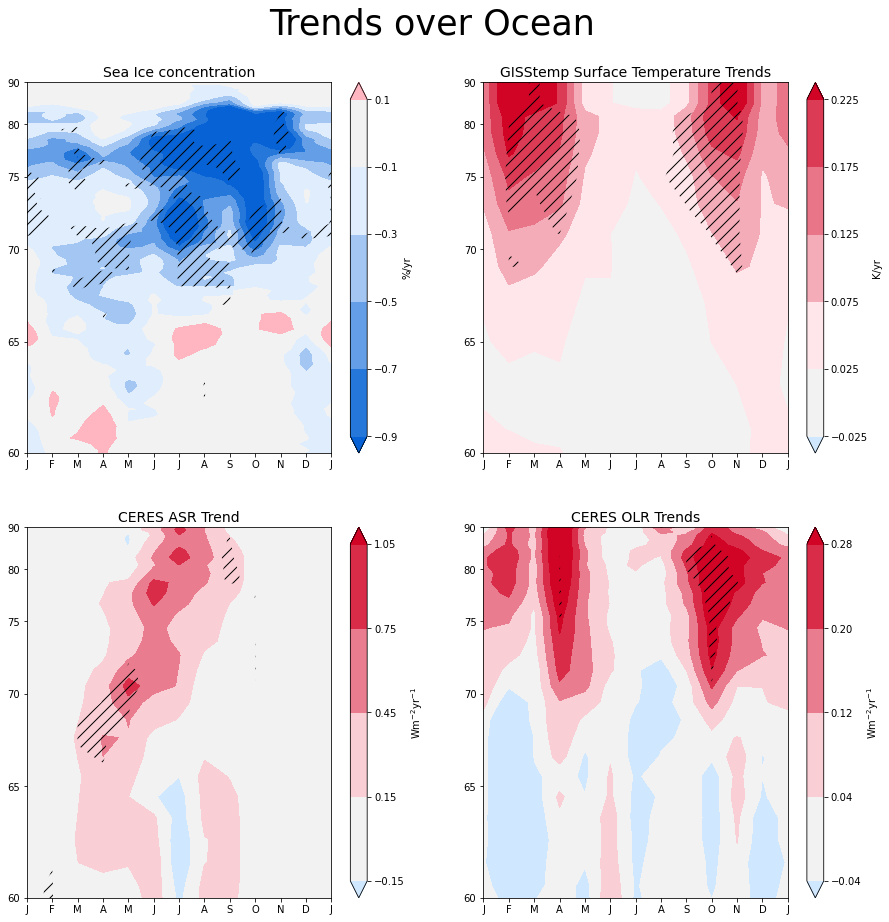

In [153]:
fig1b,axs1b = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
fig1b.suptitle('Trends over Ocean',fontsize=35,y=0.95)

axes = axs1b.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*g10010_trends['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.9,0.11,0.2),vmin=-0.9,vmax=0.9)
im0.cmap.set_over('lightpink')
# im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
stip = axes[0].contourf(g10010_statsig_wrapped['month'],lat_weighted0,g10010_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')
    
lat_weighted1 = np.sin(np.pi/180*gisstemp_seasubset_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_seasubset_trends_wrapped['month'],lat_weighted1,gisstemp_seasubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im1.cmap.set_under((0.81,0.91,1.00))
# im1 = axes[1].contourf(gisstemp_seasubset_trends_wrapped['month'],lat_weighted1,gisstemp_seasubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
stip = axes[1].contourf(gisstemp_seasubset_statsig_wrapped['month'],lat_weighted1,gisstemp_seasubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_seasubset_trends['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(asr_seasubset_trends_wrapped['month'],lat_weighted2,asr_seasubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap2,extend='both',levels=np.arange(-0.15,1.06,0.30),vmin=-1.05,vmax=1.05)
im2.cmap.set_under((0.81,0.91,1.00))
# im2 = axes[2].contourf(asr_seasubset_trends_wrapped['month'],lat_weighted2,asr_seasubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
stip = axes[2].contourf(asr_seasubset_statsig_wrapped['month'],lat_weighted2,asr_seasubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_seasubset_trends['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_seasubset_trends_wrapped['month'],lat_weighted3,olr_seasubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im3.cmap.set_under((0.81,0.91,1.00))
# im3 = axes[3].contourf(olr_seasubset_trends_wrapped['month'],lat_weighted3,olr_seasubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
stip = axes[3].contourf(olr_seasubset_statsig_wrapped['month'],lat_weighted3,olr_seasubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')


#### Land subset data

In [136]:
gisstemp_landsubset_trends_wrapped = xr.concat([gisstemp_landsubset_trends,gisstemp_landsubset_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_landsubset_statsig_wrapped = xr.concat([gisstemp_landsubset_statsig,gisstemp_landsubset_statsig[0].assign_coords({'month':13})],dim='month')

asr_landsubset_trends_wrapped = xr.concat([asr_landsubset_trends,asr_landsubset_trends[0].assign_coords({'month':13})],dim='month')
asr_landsubset_statsig_wrapped = xr.concat([asr_landsubset_statsig,asr_landsubset_statsig[0].assign_coords({'month':13})],dim='month')

olr_landsubset_trends_wrapped = xr.concat([olr_landsubset_trends,olr_landsubset_trends[0].assign_coords({'month':13})],dim='month')
olr_landsubset_statsig_wrapped = xr.concat([olr_landsubset_statsig,olr_landsubset_statsig[0].assign_coords({'month':13})],dim='month')

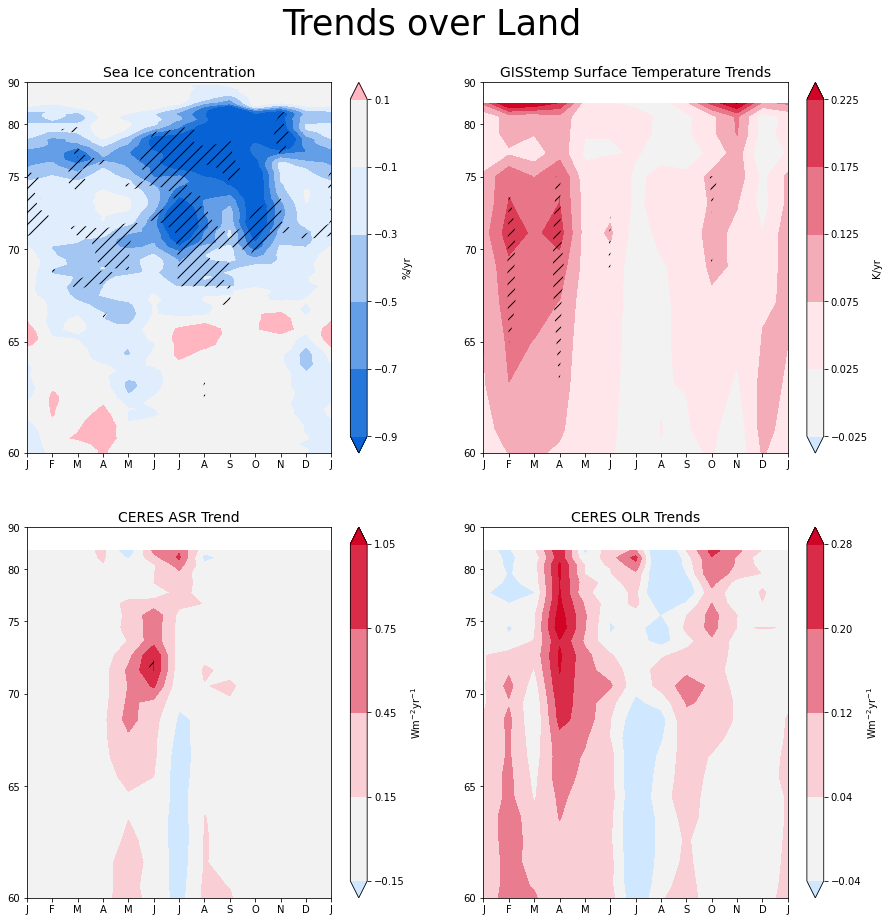

In [152]:
fig1c,axs1c = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
fig1c.suptitle('Trends over Land',fontsize=35,y=0.95)

axes = axs1c.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*g10010_trends['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.9,0.11,0.2),vmin=-0.9,vmax=0.9)
im0.cmap.set_over('lightpink')
# im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
stip = axes[0].contourf(g10010_statsig_wrapped['month'],lat_weighted0,g10010_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')
    
lat_weighted1 = np.sin(np.pi/180*gisstemp_landsubset_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_landsubset_trends_wrapped['month'],lat_weighted1,gisstemp_landsubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im1.cmap.set_under((0.81,0.91,1.00))
# im1.cmap.set_under([0,0.67,1])
# im1 = axes[1].contourf(gisstemp_landsubset_trends_wrapped['month'],lat_weighted1,gisstemp_landsubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
stip = axes[1].contourf(gisstemp_landsubset_statsig_wrapped['month'],lat_weighted1,gisstemp_landsubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_landsubset_trends['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(asr_landsubset_trends_wrapped['month'],lat_weighted2,asr_landsubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap2,extend='both',levels=np.arange(-0.15,1.06,0.30),vmin=-1.05,vmax=1.05)
im2.cmap.set_under((0.81,0.91,1.00))
# im2 = axes[2].contourf(asr_landsubset_trends_wrapped['month'],lat_weighted2,asr_landsubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
stip = axes[2].contourf(asr_landsubset_statsig_wrapped['month'],lat_weighted2,asr_landsubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_landsubset_trends['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_landsubset_trends_wrapped['month'],lat_weighted3,olr_landsubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im3.cmap.set_under((0.81,0.91,1.00))
# im3 = axes[3].contourf(olr_landsubset_trends_wrapped['month'],lat_weighted3,olr_landsubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
stip = axes[3].contourf(olr_landsubset_statsig_wrapped['month'],lat_weighted3,olr_landsubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')
